<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Dive_Prediction_MatrixDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data

Supervized Learning on Distance Matrix

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/My\ Drive/BirdDL

/content/drive/My Drive/BirdDL


In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import random
import pickle
import trip

In [4]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')
# conn = sqlite3.connect('/home/amdroy/MEGA/DATA/seabirdbank.db')

In [5]:
request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)

# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)


request = "SELECT \
            trip.id as trip, tdr.datetime, tdr.pressure \
            FROM tdr \
            INNER JOIN trip ON tdr.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# WHERE substr(bird.fieldwork,1,1) = 'P' 

tdr = pd.read_sql_query(request, conn)
tdr['datetime'] = pd.to_datetime(tdr['datetime'], format='%Y-%m-%d %H:%M:%S')
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

df = pd.merge(tdr, gps, on=['trip', 'datetime'], how='left')

# check NaN and fill with interpolations
[i for i, x in enumerate(df['lon'].isna()) if x]


df['lon'] = df['lon'].interpolate(method='polynomial', order=2)
df['lat'] = df['lat'].interpolate(method='polynomial', order=2)


bad_trip = ['P1111_9_SV_T1', 'P1111_13_SV_T6', 'P1111_41_SV_T2', 'P1111_46_SV_T5', 'P1111_52_SV_T1',
            'P1112_4_SV_T2', 'P1112_26_SV_T5', 'P1112_36_SV_T1', 'P1112_36_SV_T2', 'P1113_41_SV_T3',
           'P1113_50_SV_T2']

no_loop = ['P1112_26_SV_T1', 'P1112_26_SV_T2', 'P1112_26_SV_T3', 'P1112_26_SV_T4']


### remove bad data
idx = df.index[[(t in bad_trip or t in no_loop) for t in df.trip]]
df = df.drop(idx)

df

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
1035988,P1113_50_SV_T1,2013-11-24 13:09:17,-1.01,-77.264229,-11.773601
1035989,P1113_50_SV_T1,2013-11-24 13:09:18,-1.07,-77.264221,-11.773701
1035990,P1113_50_SV_T1,2013-11-24 13:09:19,-1.07,-77.264191,-11.773771
1035991,P1113_50_SV_T1,2013-11-24 13:09:20,-1.01,-77.264168,-11.773826


In [6]:
%%time
trajs = []
threshold = 1
radius = 500
n = 1
for k in df.trip.unique():
    df_trip = df[df.trip == k]
    
    t = trip.Trip(df_trip)
    t.add_dive(threshold)

    trajs.append(t.df)
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(df.trip.unique())))
    n+=1

Trip [170/170]
CPU times: user 19.9 s, sys: 385 ms, total: 20.3 s
Wall time: 20.2 s


In [7]:
test_trajs_idx = np.random.randint(0, len(df.trip.unique()), 30)

test_trajs = [trajs[i] for i in test_trajs_idx]
train_trajs = [trajs[i] for i in range(len(df.trip.unique())) if i not in test_trajs_idx]

## Neural Network

In [8]:
# pytorch materials
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [9]:
class Sampler:
    def __init__(self, trajs, epoch, batch_size):
        # raw trajectories
        self.trajs = trajs
        self.n = len(trajs)

        # sample input specificities
        self.epoch = epoch
        self.batch_size = batch_size
    
    def dist_ortho(self, lon1, lat1, lon2, lat2):
        R = 6377726
        pi = np.pi
        a = np.sin((lat1 - lat2)/2*pi/180)**2
        b = np.cos(lat1*pi/180)*np.cos(lat2*pi/180)
        c = np.sin((lon1- lon2)/2* pi/180)**2

        dist = R * 2* np.arcsin( np.sqrt(a + b*c))
        return dist

    def sample_one(self):
        # look for a long trip
        dt = []
        while len(dt) < epoch:
            traj_idx = np.random.randint(self.n)
            dt = self.trajs[traj_idx]

        # select part of this trip
        epoch_idx = np.random.randint(2, len(dt)-epoch)

        input_trajs = dt.loc[epoch_idx:epoch_idx+epoch-1, ('lon', 'lat')]
        output_trajs = dt.loc[epoch_idx:epoch_idx+epoch-1, 'dive']

        lon = np.vstack([input_trajs.lon.values for i in range(len(input_trajs))])
        lat = np.vstack([input_trajs.lat.values for i in range(len(input_trajs))])
        dist_matrix = self.dist_ortho(lon, lat, lon.T, lat.T)

        # change resolution
        output = [np.max(output_trajs[i:i+11]) for i in range(len(output_trajs)) if i%10==0]

        return (dist_matrix, np.array(output), np.array(input_trajs))


    def sample(self):
        input_batch = []
        output_batch = []
        for i in range(self.batch_size):

            (x,y,z) = self.sample_one()

            # add it to batch
            input_batch.append(x)
            output_batch.append(y)

        # convert to tensor
        input_batch = torch.FloatTensor(input_batch)
        output_batch = torch.FloatTensor(output_batch)

        return (input_batch.reshape((4,1,600,600)), output_batch.reshape((4,1,1,60)))

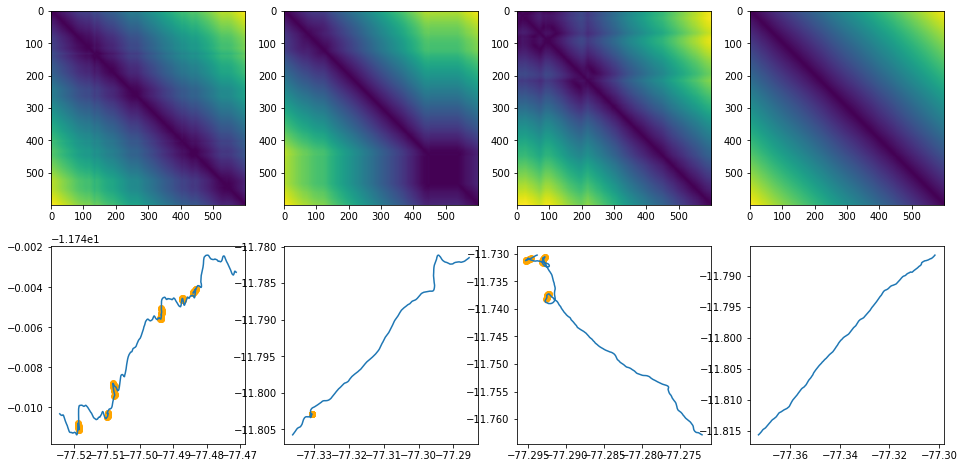

In [10]:
# Hyperparameters
epoch = 600
batch_size = 4
learning_rate = 0.01

train = Sampler(train_trajs, epoch, batch_size)
test = Sampler(test_trajs, epoch, batch_size)

plt.figure(figsize=(16, 8))

for i in range(4):
    (x, y, z) = train.sample_one()

    yy = [y[i] for i in range(len(y)) for k in range(10) ]

    plt.subplot(2, 4, 1+i)
    plt.imshow(x)

    plt.subplot(2, 4, 5+i)
    plt.plot(z[:,0], z[:,1])
    plt.scatter(z[np.where(yy),0], z[np.where(yy),1], c='orange')

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        
        ## reduce temporal dimension -------------------------------------------
        self.cnn_input_1 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 50, stride = 2, padding = 24, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 15, stride = 2, padding = 7, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 11, stride = 2, padding = 5, dilation = 4)
        )

        self.cnn_4 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )
        
        ## image to timeseries -------------------------------------------------
        self.cnn_output_5 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size = (11,10), stride = (1,1), padding = (5,3), dilation = (1,4)),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size = (11,6), stride = (1,1), padding = (5,0), dilation = (1,4)),
            nn.ReLU()
        ) 
        
        self.pooling_5 = nn.Sequential(
            nn.AdaptiveAvgPool2d((60,1)),
            nn.Conv2d(1, 1, kernel_size = (11,1), stride = (1,1), padding = (5,0), dilation = (1,1)),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        out = self.cnn_input_1(x)
        out = self.pooling_1(out)
        out = self.cnn_input_2(out)
        out = self.pooling_2(out)
        out = self.cnn_input_3(out)
        out = self.pooling_3(out)
        out = self.cnn_4(out)
        out = self.cnn_output_5(out)
        out = self.pooling_5(out)

        return out.reshape((batch_size, 1, 1, 60))


In [14]:
x,y = train.sample()
x.size()

torch.Size([4, 1, 600, 600])

In [15]:
model = ConvNet()
out = model(x)
out.size()

torch.Size([4, 1, 1, 60])

In [16]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
criterion(out, y)

tensor(0.6513, grad_fn=<BinaryCrossEntropyBackward>)

In [18]:
# switch to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
### DATALOADER
nb_train = 10000
nb_test = 3000

dataset_test = []
for i in range(nb_test):
    (x, y, z) = test.sample_one()
    dataset_test.append((x,y))
    if i%100 == 0:
      print('[{}/{}]'.format(i, nb_test))


test_loader = DataLoader(dataset_test, batch_size=4, drop_last=True)

[0/3000]
[100/3000]
[200/3000]
[300/3000]
[400/3000]
[500/3000]
[600/3000]
[700/3000]
[800/3000]
[900/3000]
[1000/3000]
[1100/3000]
[1200/3000]
[1300/3000]
[1400/3000]
[1500/3000]
[1600/3000]
[1700/3000]
[1800/3000]
[1900/3000]
[2000/3000]
[2100/3000]
[2200/3000]
[2300/3000]
[2400/3000]
[2500/3000]
[2600/3000]
[2700/3000]
[2800/3000]
[2900/3000]


In [ ]:
list_score =[]
list_loss = []

model = ConvNet()
model = model.to(device)

for i in range(nb_train):

    # Train the model
    model.train()
    x, y = train.sample()

    # send to GPU
    x, y = x.to(device), y.to(device)

    # Run the forward pass
    out = model(x)
    loss = criterion(out, y)

    # Backprop and perform optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if (i + 1) % 50 == 0:  
        # Test the model
        model.eval()
        with torch.no_grad():
            real = []
            estim = []
            for batch, (x, y) in enumerate(test_loader):

                x = x.reshape((4,1,600,600)).float()
                y = y.reshape((4,1,1,60)).float()
                
                # send to GPU
                x, y = x.to(device), y.to(device)
                out = model(x)
                
                # dive prediction
                real.append( y.cpu().reshape(4*60).detach().numpy() )
                estim.append( out.cpu().reshape(4*60).detach().numpy() )

            real = np.hstack(real)
            estim = np.hstack(estim)

            # no dive prediction performance
            no_dive_prediction = [estim[i] for i in range(estim.shape[0]) if not real[i]]
            true_no_dive = 1-np.sum(no_dive_prediction)/len(no_dive_prediction)

            # dive prediction performance
            dive_prediction = [estim[i] for i in range(estim.shape[0]) if real[i]]
            true_dive = np.sum(dive_prediction)/len(dive_prediction)
        
            score = (true_no_dive + true_dive)/2

            list_loss.append(loss.item())
            list_score.append(score)


        print('Step [{}/{}], Loss: {:.4f}, Accuracy: {} %'
                .format(i + 1, nb_train, loss.item(), score*100))

Step [50/10000], Loss: 0.5989, Accuracy: 49.98251777857144 %
Step [100/10000], Loss: 0.6131, Accuracy: 49.98251777857144 %
Step [150/10000], Loss: 0.6100, Accuracy: 49.98251777857144 %
Step [200/10000], Loss: 0.6042, Accuracy: 49.98251777857144 %
Step [250/10000], Loss: 0.6099, Accuracy: 49.98251777857144 %
Step [300/10000], Loss: 0.5979, Accuracy: 49.98251777857144 %
Step [350/10000], Loss: 0.6237, Accuracy: 49.98251777857144 %
Step [400/10000], Loss: 0.5940, Accuracy: 49.98251777857144 %
